# Core Imports

In [ ]:
# Generic Imports
import re
from functools import partial, cached_property
from collections import defaultdict
from itertools import combinations, chain
from ast import literal_eval

# Numeric imports
import pandas as pd
import numpy as np

# File I/O
from pathlib import Path
import csv, json, openpyxl, pickle

# Logging
from tqdm import tqdm as tqdm_text
from tqdm.notebook import tqdm as tqdm_notebook

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Generator, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdChemReactions

from openff.toolkit import ForceField
from openff.toolkit.topology import Topology, Molecule

from openforcefields.openforcefields import get_forcefield_dirs_paths
OPENFF_DIR = Path(get_forcefield_dirs_paths()[0])

# File and chemistry type definitions

In [ ]:
nmer_name = 'trimers'
# lattice_size = '1x1x1'
lattice_size = '5x5x5'

topo_dir = Path('Topologies') / nmer_name / lattice_size
ics_dir = Path('Interchanges') / nmer_name / lattice_size
lammps_dir = Path('LAMMPS') / nmer_name / lattice_size
omm_dir = Path('OpenMM') / nmer_name / lattice_size

# Creating OpenMM and LAMMPS systems

## Harvest and tabulate paths + info for all Interchange and Topology files

In [ ]:
import pandas as pd
from polymerist.genutils.fileutils.pathutils import assemble_path


MOL_MASTER_DIR = Path('polymer_structures')
TAGS = (
    'mechanism',
    'mol_name',
    'oligomer_size',
    'lattice_size'
)

records = []
for mol_dir in MOL_MASTER_DIR.glob('**/[0-9]x[0-9]x[0-9]'):
    mol_info = {
        tag : value
            for tag, value in zip(TAGS, mol_dir.relative_to(MOL_MASTER_DIR).parts)
    }
    mol_info['directory'] = mol_dir
    
    inc_path = assemble_path(mol_dir, prefix=mol_info['lattice_size'], postfix=mol_info['mol_name'], extension='pkl')
    if inc_path.exists():
        mol_info['interchange_path'] = inc_path
    
    top_path = assemble_path(mol_dir, prefix=mol_info['lattice_size'], postfix=mol_info['mol_name'], extension='sdf')
    if top_path.exists():
        mol_info['topology_path'] = top_path

    records.append(mol_info)

mol_file_frame = pd.DataFrame.from_records(records)
groups = mol_file_frame.groupby(['lattice_size'])
# groups = mol_file_frame.groupby(['lattice_size', 'mechanism'])

# Defining utilities

## LAMMPS functions

In [ ]:
from openff.interchange import Interchange
from openff.interchange.components.mdconfig import MDConfig

def lammps_files_from_interchange(interchange : Interchange, lmp_input_path : Path, lmp_data_path : Path) -> None:
    '''Convert and OpenFF interchange to LAMMPS structure and input files'''
    # validating Paths
    assert(lmp_input_path.suffix == '.in')
    assert(lmp_data_path.suffix in ('.lmp', '.lammps'))
    
    # writing out files
    interchange.to_lammps(lmp_data_path) # MD data file
    mdc = MDConfig.from_interchange(interchange)
    mdc.write_lammps_input(lmp_input_path) # input directive file

    # replacing generic lmp file with data file from above
    with lmp_input_path.open('r') as in_file:
        in_file_block = in_file.read()

    with lmp_input_path.open('w') as in_file:
        in_file.write(
            in_file_block.replace('out.lmp', f'"{lmp_data_path}"') # need surrounding double quotes to allow LAMMPS to read special symbols in filename (if present)
        )

## OpenMM functions

In [53]:
from typing import Optional

from openmm import System, Context, NonbondedForce
from openmm.unit import kilojoule_per_mole, Quantity
from polymerist.genutils.containers import RecursiveDict


NONBOND_CUTOFF_METHOD_NAMES = (
    'NoCutoff',
    'CutoffNonPeriodic',
    'CutoffPeriodic',
    'Ewald',
    'PME',
    'LJPME',
)
NONBOND_CUTOFF_METHODS = {
    idx : method_name
        for idx, method_name in sorted( # sort in ascending order by integer code
            (getattr(NonbondedForce, method_name), method_name)
                for method_name in NONBOND_CUTOFF_METHOD_NAMES
        )
}

def describe_ommsys_forces(ommsys : System) -> tuple[str, dict[str, int]]:
    '''Describes accessible parameters associated with each Force in an OpenMM system
    Also maps each Force's force_group to a unique id

    Returns the decriptive text as a string, and a dict mapping each Force's name to it's id'''
    force_map : dict[str, int] = {}
    descript_dict = RecursiveDict()

    for force in ommsys.getForces():
        force_name = force.getName()
        force_map[force_name] = force.getForceGroup()
        descript_dict[force_name]['type'] = type(force).__name__
        
        for attr in dir(force):
            if attr.startswith('get'):
                try:
                    attr_val = getattr(force, attr)()
                    if attr == 'getNonbondedMethod': # convert integer index into readable name of nonbonded cutoff method
                        attr_val = NONBOND_CUTOFF_METHODS[attr_val]
                    descript_dict[force_name][attr.removeprefix('get')] = attr_val
                except TypeError: # called when the getter expects more than 0 arguments
                    pass
                
    return descript_dict, force_map

def eval_openmm_energies(context : Context, force_name_remap : Optional[dict[str, str]]=None) -> dict[str, Quantity]:
    '''Perform an energy evaluation on an OpenMM Context'''
    if force_name_remap is None:
        force_name_remap = {}
    openmm_energies = {}

    # get global energies
    overall_state = context.getState(getEnergy=True) # get total potential energy
    openmm_energies['Potential'] = overall_state.getPotentialEnergy()
    openmm_energies['Kinetic'  ] = overall_state.getKineticEnergy()

    # get individual energies from each force type
    for i, force in enumerate(context.getSystem().getForces()):
        state = context.getState(getEnergy=True, groups={i}) # TODO : add option to keep whatever groups were there prior
        force_label = force_name_remap.get(force.getName(), force.getName()) # check if a remapped name is registered, otherwise use the Force's set name
        openmm_energies[force_label] = state.getPotentialEnergy()

    return openmm_energies

# Create MD files from Interchange, evaluate starting energies

In [ ]:
import pickle
from shutil import copyfile
from gc import collect
from rich.progress import track, Progress
from IPython.display import clear_output

from openmm import Context, Platform
from openmm.app import Simulation
from openmm.unit import angstrom, nanometer

from openff.interchange.components.mdconfig import MDConfig, _infer_constraints, get_smirnoff_defaults
from openff.interchange.constants import _PME
from openff.interchange.interop.openmm._positions import to_openmm_positions

from polymerist.lammpstools import lammpseval
from polymerist.openfftools import topology, boxvectors
from polymerist.genutils.fileutils.pathutils import assemble_path

from polymerist.genutils.textual import dict_to_indented_str
from polymerist.openmmtools import serialization, preparation
from polymerist.openmmtools.thermo import EnsembleFactory
from polymerist.openmmtools.parameters import SimulationParameters


# parameters
lattice_size = '1x1x1'
switching_function : bool = False
nonbond_cutoff : Quantity = 0.9 * nanometer

force_name_remap = { # TODO : move this to energy eval as a simple remap (suitable names are already set by Interchange)
    'vdW force'                : 'vdW',
    'Electrostatics force'     : 'Electrostatic',
    'vdW 1-4 force'            : 'vdW 1-4',
    'Electrostatics 1-4 force' : 'Electrostatic 1-4',
    'PeriodicTorsionForce'     : 'Dihedral',
    'HarmonicAngleForce'       : 'Angle',
    'HarmonicBondForce'        : 'Bond'
}
state_params : dict[str, bool] = {
    'getPositions'  : True,
    'getVelocities' : True,
    'getForces'     : True,
    'getEnergy'     : True,
    'getParameters' : True,
    'getParameterDerivatives' : False,
    'getIntegratorParameters' : True
}

targ_df = groups.get_group(lattice_size)
sim_params = SimulationParameters.from_file('sim_params.json')
ensfac = EnsembleFactory.from_thermo_params(sim_params.thermo_params)


# execute MD loop
energies = RecursiveDict()
with Progress() as progress:
    mol_task_id = progress.add_task('Generating MD files', total=len(targ_df))

    for (i, row) in targ_df.iterrows():
        # load recorded topology and interchange files
        mol_name = row.mol_name
        progress.update(mol_task_id, description=f'{row.mechanism} : {mol_name}')

        offtop = topology.topology_from_sdf(row.topology_path, allow_undefined_stereo=True)
        with row.interchange_path.open('rb') as inc_file:
            interchange = pickle.load(inc_file)
            interchange['vdW'].switch_width = (1.0 if switching_function else 0.0) * angstrom
            interchange['vdW'           ].cutoff = nonbond_cutoff
            interchange['Electrostatics'].cutoff = nonbond_cutoff
        # mdc = MDConfig.from_interchange(interchange)

        # LAMMPS
        lmp_dir : Path = row.directory / 'LAMMPS'
        lmp_dir.mkdir(exist_ok=True)

        lammps_lmp = assemble_path(lmp_dir, mol_name, extension='lammps')
        lammps_in  = assemble_path(lmp_dir, mol_name, extension='in')
        lammps_files_from_interchange(interchange, lmp_data_path=lammps_lmp, lmp_input_path=lammps_in)
        # clear_output()

        # box_params = lammpseval.get_lammps_unit_cell(lammps_in)
        energies['LAMMPS'][mol_name] = lammpseval.get_lammps_energies(lammps_in, preferred_unit=kilojoule_per_mole)

        # OpenMM
        omm_dir : Path = row.directory / 'OpenMM'
        omm_dir.mkdir(exist_ok=True)

        system = interchange.to_openmm(combine_nonbonded_forces=False)
        preparation.label_forces(system)
        integrator = ensfac.integrator(time_step=sim_params.integ_params.time_step)
        context = Context(system, integrator)
        context.setPositions(to_openmm_positions(interchange, include_virtual_sites=True))

        ## save files
        omm_sys_path   = assemble_path(omm_dir, mol_name, postfix='system'  , extension='xml')
        omm_state_path = assemble_path(omm_dir, mol_name, postfix='state'   , extension='xml')
        omm_top_path   = assemble_path(omm_dir, mol_name, postfix='topology', extension='sdf') # TODO : PDB?

        copyfile(row.topology_path, omm_top_path)
        serialization.serialize_system(omm_sys_path, system)
        serialization.serialize_state_from_context(omm_state_path, context, state_params=state_params)

        ## evaluate energies
        openmm_energies = eval_openmm_energies(context, force_name_remap=force_name_remap)
        assert(openmm_energies['Kinetic'] == 0.0*kilojoule_per_mole) # check total KE to verify no integration is being done
        energies['OpenMM'][mol_name] = openmm_energies

        progress.advance(mol_task_id)
        collect() # manual garbage collector call to try to alleviate memory issues

In [37]:
energy_dir = Path('energy_tables')
energy_dir.mkdir(exist_ok=True)
edfs = {}

for (label, energies_dict) in energies.items():
    energy_path = assemble_path(energy_dir, label, postfix=lattice_size, extension='csv')
    edf = pd.DataFrame.from_dict(energies_dict, orient='index')
    edf.to_csv(energy_path)
    edfs[label] = edf

# Comparing energies

## Loading energy tables and comparing contributions

In [32]:
from functools import reduce
from operator import add

pd.options.display.float_format = '{:.4f}'.format # disable scientific notation

@dataclass
class TableFormats:
    sum_terms : dict[str, list[str]]
    del_terms : list[str]

formats = {
    'OpenMM' : TableFormats(
        sum_terms = {
            'vdW' : ['vdW', 'vdW 1-4'],
            'Coulomb' : ['Electrostatic', 'Electrostatic 1-4']
        },
        del_terms = ['Kinetic']
    ),
    'LAMMPS' : TableFormats(
        sum_terms = {
            'vdW' : ['vdW', 'Dispersion'],
            'Dihedral' : ['Proper Torsion', 'Improper Torsion'],
            'Coulomb'  : ['Coulomb Short', 'Coulomb Long']
        },
        del_terms = ['Nonbonded']
    ),
}

# apply reformatting to respective tables
for platform, energy_df in edfs.items():
    fmt = formats[platform]

    # combine selected terms
    for combined_contrib, contribs in fmt.sum_terms.items():
        new_term = reduce(add, (energy_df[contrib] for contrib in contribs)) # merge contributions into a single new named term
        energy_df.drop(columns=contribs, inplace=True) # clear contributions
        energy_df[combined_contrib] = new_term # done after drop to ensure name clashes don't result in extra deletion
    
    # delete redundant terms
    for del_contrib in fmt.del_terms:
        energy_df.drop(columns=[del_contrib], inplace=True) # clear contributions

    # globals()[f'{fmt.table_key.lower()}_table'] = energy_df
    # energy_df.to_csv(table_out_path)

In [36]:
col_order = ['Bond', 'Angle', 'Dihedral', 'vdW', 'Coulomb', 'Potential']

diff = edfs['LAMMPS'] - edfs['OpenMM']
diff[col_order]

,Bond,Angle,Dihedral,vdW,Coulomb,Potential
poly(2-(2-Hydroxyethoxy)ethanol-co-hexanedioic acid),0.00013449073389892874 kJ/mol,7.087032957997508e-05 kJ/mol,-2.7845171928220225e-06 kJ/mol,-261.0069622993469 kJ/mol,0.023971534867314404 kJ/mol,-609.336199760437 kJ/mol
"poly(Ethane-1,2-diol-co-4-[2-(4-carboxyphenoxy)ethoxy]benzoic acid)",-0.0023148862995867603 kJ/mol,0.00047293215868648986 kJ/mol,-2.9281624833288333e-05 kJ/mol,-0.38848103835778147 kJ/mol,0.04067261616535234 kJ/mol,0.04184410489710899 kJ/mol
"poly(Pentane-1,5-diol-co-Heptanedioic acid)",-0.0001135849563524971 kJ/mol,0.0005174014759177226 kJ/mol,-2.028288889732721e-05 kJ/mol,7.002328742528334 kJ/mol,-0.22612920920801116 kJ/mol,7.218465141253546 kJ/mol
"poly(2-(2-Hydroxyethoxy)ethanol-co-Benzene-1,3-dicarboxylic acid)",-0.0001378505211278025 kJ/mol,-2.9400098242149397e-05 kJ/mol,-0.00011750043539393573 kJ/mol,2169935219.4375 kJ/mol,-0.2834140495360771 kJ/mol,2169939365.46875 kJ/mol
"poly(Ethane-1,2-diol-co-naphthalene-2,6-dicarboxylic acid)",-0.0013562622277731862 kJ/mol,-7.786958065025829e-05 kJ/mol,-8.377879061782778e-05 kJ/mol,452.49845123291016 kJ/mol,-0.128312329065011 kJ/mol,821.1002106666565 kJ/mol
...,...,...,...,...,...,...
"poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hexoxymethyl]-1,3-dioxolan-2-one-co-[3-(aminomethyl)phenyl]methanamine)",-0.0027183652274516135 kJ/mol,-0.00015264707019468915 kJ/mol,5.1884573053939675e-05 kJ/mol,250.88007527589798 kJ/mol,-0.46103571821777223 kJ/mol,237.1681958436966 kJ/mol
"poly(4-[[3-[(2-oxo-1,3-dioxolan-4-yl)methoxy]phenoxy]methyl]-1,3-dioxolan-2-one-co-2-[2-(2-aminoethoxy)ethoxy]ethanamine)",-0.0027167304561999117 kJ/mol,0.00027374233263799397 kJ/mol,6.822962677688338e-05 kJ/mol,1275.5544266216457 kJ/mol,-0.737157404894333 kJ/mol,1278.4190743602812 kJ/mol
"poly(4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hexoxymethyl]-1,3-dioxolan-2-one-co-N-(3-aminopropyl)propane-1,3-diamine)",-0.0013260222966664514 kJ/mol,0.0006026737136153315 kJ/mol,-3.5051010627284995e-07 kJ/mol,41.689143903553486 kJ/mol,-0.5067992675585629 kJ/mol,38.20229330658913 kJ/mol
"poly(4-[[4-[2-[4-[(2-oxo-1,3-dioxolan-4-yl)methoxy]phenyl]propan-2-yl]phenoxy]methyl]-1,3-dioxolan-2-one-co-dodecane-1,12-diamine)",0.003180332119882223 kJ/mol,0.0004104067468233552 kJ/mol,-0.00013045783754250806 kJ/mol,-1.0690593493056042 kJ/mol,-1.0581837622098647 kJ/mol,-1.0523683943119977 kJ/mol


(array([139.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-6.87618279e+01,  5.92307043e+15,  1.18461409e+16,  1.77692113e+16,
         2.36922817e+16,  2.96153521e+16,  3.55384226e+16,  4.14614930e+16,
         4.73845634e+16,  5.33076338e+16,  5.92307043e+16]),
 <BarContainer object of 10 artists>)

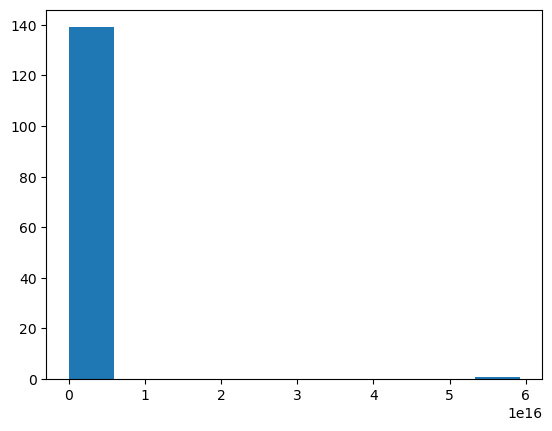

In [58]:
plt.hist([i._value for i in edfs['OpenMM']['vdW']])

In [63]:
sorted(edfs['OpenMM']['vdW'], reverse=True)

[Quantity(value=5.923070427319501e+16, unit=kilojoule/mole),
 Quantity(value=801552432365565.9, unit=kilojoule/mole),
 Quantity(value=801492302823421.8, unit=kilojoule/mole),
 Quantity(value=801491765952509.5, unit=kilojoule/mole),
 Quantity(value=801479954792445.8, unit=kilojoule/mole),
 Quantity(value=801476129587197.4, unit=kilojoule/mole),
 Quantity(value=285130732077054.75, unit=kilojoule/mole),
 Quantity(value=149257529065471.4, unit=kilojoule/mole),
 Quantity(value=141347658924031.06, unit=kilojoule/mole),
 Quantity(value=134061481787390.52, unit=kilojoule/mole),
 Quantity(value=12312908922878.846, unit=kilojoule/mole),
 Quantity(value=10968647073791.37, unit=kilojoule/mole),
 Quantity(value=2628986339327.0815, unit=kilojoule/mole),
 Quantity(value=2628889083903.369, unit=kilojoule/mole),
 Quantity(value=371451527165.8893, unit=kilojoule/mole),
 Quantity(value=208274276351.37167, unit=kilojoule/mole),
 Quantity(value=53185888254.90557, unit=kilojoule/mole),
 Quantity(value=13294

In [62]:
sorted(edfs['LAMMPS']['vdW'], reverse=True)

[Quantity(value=5.923095908543032e+16, unit=kilojoule/mole),
 Quantity(value=801531785750203.0, unit=kilojoule/mole),
 Quantity(value=801528954411172.4, unit=kilojoule/mole),
 Quantity(value=801528576525709.2, unit=kilojoule/mole),
 Quantity(value=801522091826604.0, unit=kilojoule/mole),
 Quantity(value=801519552404177.8, unit=kilojoule/mole),
 Quantity(value=285126430920551.4, unit=kilojoule/mole),
 Quantity(value=149259699000957.44, unit=kilojoule/mole),
 Quantity(value=141340704906803.22, unit=kilojoule/mole),
 Quantity(value=134059969627128.19, unit=kilojoule/mole),
 Quantity(value=12312970909236.363, unit=kilojoule/mole),
 Quantity(value=10968258843437.045, unit=kilojoule/mole),
 Quantity(value=2628966999359.3237, unit=kilojoule/mole),
 Quantity(value=2628885574898.147, unit=kilojoule/mole),
 Quantity(value=371454087424.9912, unit=kilojoule/mole),
 Quantity(value=208275355768.0891, unit=kilojoule/mole),
 Quantity(value=53185261383.19535, unit=kilojoule/mole),
 Quantity(value=13294

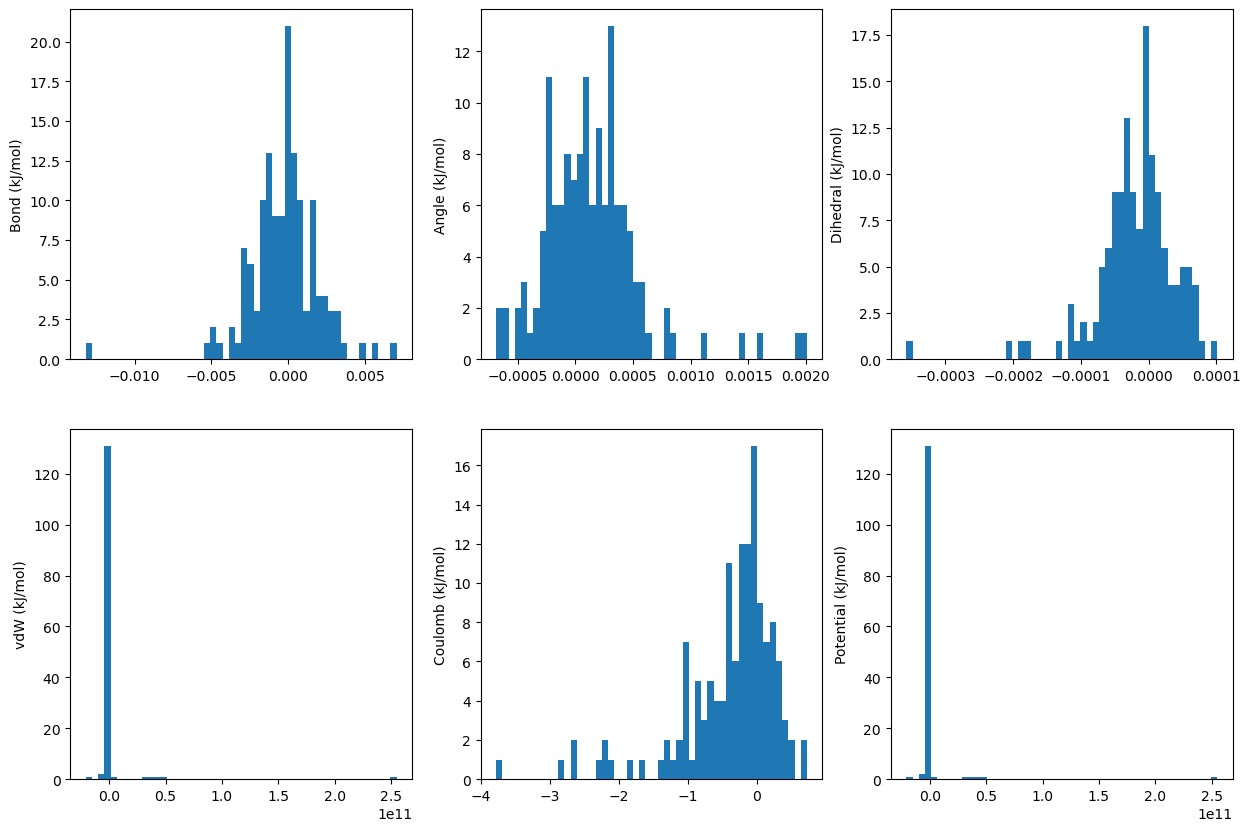

In [52]:
import matplotlib.pyplot as plt
from polymerist.graphics.plotutils import presize_subplots

fig, ax = presize_subplots(nrows=2, ncols=3)
for col, axis in zip(col_order, ax.flatten()):
    heights, bins, patches = axis.hist([i._value for i in diff[col]], bins=50)
    axis.set_ylabel(f'{col} (kJ/mol)')

## Evaluating energies with drivers

In [ ]:
from openff.interchange.drivers.openmm import get_openmm_energies, _get_openmm_energies
from openff.interchange.drivers.lammps import get_lammps_energies, _get_lammps_energies,  _find_lammps_executable
from openff.units.openmm import to_openmm as openff_units_to_openmm

In [ ]:
{
    contrib : openff_units_to_openmm(value).in_units_of(kilocalorie_per_mole)
        for contrib, value in get_openmm_energies(interchange, detailed=True, combine_nonbonded_forces=False).energies.items()
}

In [ ]:
get_lammps_energies(interchange).energies

## Comparing ParmEd energy decomposition to native OpenMM force-group-based decomposition

In [ ]:
import parmed
from openmm.openmm import Force

NULL_ENERGY = 0.0*kilojoule_per_mole

sim = omm_sims['urethane']['urethane_41']
# assign and initialize unique force groups for simulation
for i, force in enumerate(sim.system.getForces()):
    force.setForceGroup(i)
    # print(force.getName(), force.getForceGroup())
sim.context.reinitialize(preserveState=True) # need to reinitialize to get force labelling changes to "stick"

# energies from OpenMM force groups
print('\nOpenMM:')
print('='*30)
omm_energies = {}

## extract total energies for state
overall_state = sim.context.getState(getEnergy=True) # get total potential energy
PE = overall_state.getPotentialEnergy()
omm_energies['Total Potential Energy'] = PE

KE = overall_state.getKineticEnergy()
assert(KE == NULL_ENERGY)

for i, force in enumerate(sim.system.getForces()):
    state = sim.context.getState(getEnergy=True, groups={i})
    force_name = force.getName().removesuffix('Force')
    pe = state.getPotentialEnergy()

    omm_energies[force_name] = pe
    print(f'{force_name} : {pe}')

## converting name to match with ParmEd for comparison
namemap = {
    'Nonbonded' : 'bond',
    'PeriodicTorsion' : 'angle',
    'HarmonicAngle' : 'dihedral',
    'HarmonicBond' : 'urey_bradley',
    'Total Potential Energy' : 'total'
}
compat_omm_energies = {
    namemap[contrib] : energy
        for contrib, energy in omm_energies.items()
}

total = sum(omm_energies.values(), start=NULL_ENERGY) # need "seed" to have Quantity datatype to sum
print(f'{general.GREEK_UPPER["delta"]}E_contrib: ', PE - total)

# ParmEd energy decomposition
print('\nParmEd:')
print('='*30)
parm_energies = {}
parm_struct = parmed.openmm.load_topology(sim.topology, sim.system)
for contrib, energy_val in parmed.openmm.energy_decomposition(parm_struct, sim.context).items():
    parm_energies[contrib] = energy = energy_val*kilocalorie_per_mole # assign proper units
    print(contrib, energy.in_units_of(kilojoule_per_mole))